In [1]:
import json
import time
import sqlite3

import pandas as pd
import numpy as np

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr
from datetime import datetime

## Read in data

### Read in station info

In [2]:
with open('../buoy_station_name.json','r') as outfile:
    stndata=json.load(outfile)

data=[]
for ids in stndata:
    info = stndata[ids]
    data.append([ids,info['STN'],info['LAT'],info['LON'],info['LOCATE'],info['OWNER']])
    
# set up column names
columns = ['ST', 'STN','LAT','LON','LOCATE','OWNER']

# list to DataFrame 
stdf = pd.DataFrame(data=data,columns=columns)

### Read in data from sqlite and change type

In [3]:
def read_sql(filename):
    conn = sqlite3.connect(filename, timeout=10)
    df = pd.read_sql("SELECT * FROM status",con=conn)
    conn.close()
    return df

filename = '../buoy_data.sqlite.db'
df = read_sql(filename)

df['DATETIME'] = pd.to_datetime(df['DATETIME'])

df['H']        = df['H'].astype('float')/100.
df['T']        = df['T'].astype('float')
df['Tmean']    = df['Tmean'].astype('float')

df['Temp']     = df['Temp'].astype('float')
df['Zt']       = df['Zt'].astype('float')

df['Vm']       = df['Vm'].astype('float')
df['Dm']       = df['Dm'].astype('float')
df['Vg']       = df['Vg'].astype('float')
df['Vms']      = df['Vms'].astype('float')
df['Vgs']      = df['Vgs'].astype('float')
df['Zv']       = df['Zv'].astype('float')

df['P']        = df['P'].astype('float')

df['Vmsat']    = df['Vmsat'].astype('float')

### add STN station name variable 

In [4]:
def label_stname (row):
    if row['ST'] in stndata:
        return stndata[row['ST']]['STN']
    
df['STN'] = df.apply (lambda row: label_stname(row), axis=1)

### Spearman Correlation Coefficient

In [5]:
def corr_coef(x,y):
    correlation, p = spearmanr(x, y)
    print('Correlation:', correlation)
    print('p-value:', p)
    if p >= 0.05:
        print('H0 is accepted')
    else:
        print('H0 is rejected')

In [6]:
dataset = df[['STN','ST','DATETIME','H','Temp','P','Vm','Vmsat']]
df_index = (dataset['DATETIME']>datetime(2015,1,1,0)) & (dataset['DATETIME']<datetime(2020,1,1,0))
dataset = dataset[df_index]

stnlist=['新竹浮標','龜山島浮標','臺東外洋浮標','龍洞浮標','小琉球浮標','花蓮浮標','東沙島浮標','馬祖浮標']
for stn in stnlist:
    data = dataset[dataset['STN'].isin([stn])]
    data = data.dropna()
    x = data['Vmsat']
    y = data['Vm']
    print('-------------')
    print('std : ',stn)     
    corr_coef(x,y)

-------------
std :  新竹浮標
Correlation: 0.8757377203144044
p-value: 0.0
H0 is rejected
-------------
std :  龜山島浮標
Correlation: 0.7639873453153011
p-value: 0.0
H0 is rejected
-------------
std :  臺東外洋浮標
Correlation: 0.8957072112315705
p-value: 0.0
H0 is rejected
-------------
std :  龍洞浮標
Correlation: 0.7613286672607933
p-value: 0.0
H0 is rejected
-------------
std :  小琉球浮標
Correlation: 0.4777087280688122
p-value: 3.258224956149057e-254
H0 is rejected
-------------
std :  花蓮浮標
Correlation: 0.5758748932008706
p-value: 5.87653445456e-313
H0 is rejected
-------------
std :  東沙島浮標
Correlation: 0.9181043857679041
p-value: 0.0
H0 is rejected
-------------
std :  馬祖浮標
Correlation: 0.9159437700932689
p-value: 0.0
H0 is rejected


### Clean data

In [7]:
from datetime import datetime
dataset = df[['STN','ST','DATETIME','H','Temp','P','Vm','Vmsat']]

df_index = (dataset['DATETIME']>datetime(2015,1,1,0)) & (dataset['DATETIME']<datetime(2020,1,1,0))
dataset = dataset[df_index]

#stnlist=['新竹浮標','龜山島浮標','臺東外洋浮標','龍洞浮標','小琉球浮標','花蓮浮標','東沙島浮標','馬祖浮標']

stnlist=['新竹浮標','東沙島浮標','臺東外洋浮標','馬祖浮標']
#stnlist=['東沙島浮標']
#stnlist=['臺東外洋浮標']
dataset = dataset[dataset['STN'].isin(stnlist)]

dataset = dataset.dropna()

/Users/dschen/anaconda3/envs/ai/lib/python3.7/site-packages/seaborn/axisgrid.py:88: UserWarning: Glyph 26032 (\N{CJK UNIFIED IDEOGRAPH-65B0}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/Users/dschen/anaconda3/envs/ai/lib/python3.7/site-packages/seaborn/axisgrid.py:88: UserWarning: Glyph 31481 (\N{CJK UNIFIED IDEOGRAPH-7AF9}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/Users/dschen/anaconda3/envs/ai/lib/python3.7/site-packages/seaborn/axisgrid.py:88: UserWarning: Glyph 28014 (\N{CJK UNIFIED IDEOGRAPH-6D6E}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/Users/dschen/anaconda3/envs/ai/lib/python3.7/site-packages/seaborn/axisgrid.py:88: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/Users/dschen/anaconda3/envs/ai/lib/python3.7/site-packages/seaborn/axisgrid.py:88: UserWarning: Glyph 33274 (\N{CJK UNIFIED IDEOGRAPH-81FA}) mi

<Figure size 3200x1600 with 0 Axes>

/Users/dschen/anaconda3/envs/ai/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26032 (\N{CJK UNIFIED IDEOGRAPH-65B0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dschen/anaconda3/envs/ai/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31481 (\N{CJK UNIFIED IDEOGRAPH-7AF9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dschen/anaconda3/envs/ai/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28014 (\N{CJK UNIFIED IDEOGRAPH-6D6E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dschen/anaconda3/envs/ai/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dschen/anaconda3/envs/ai/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 33274 (\N{CJK

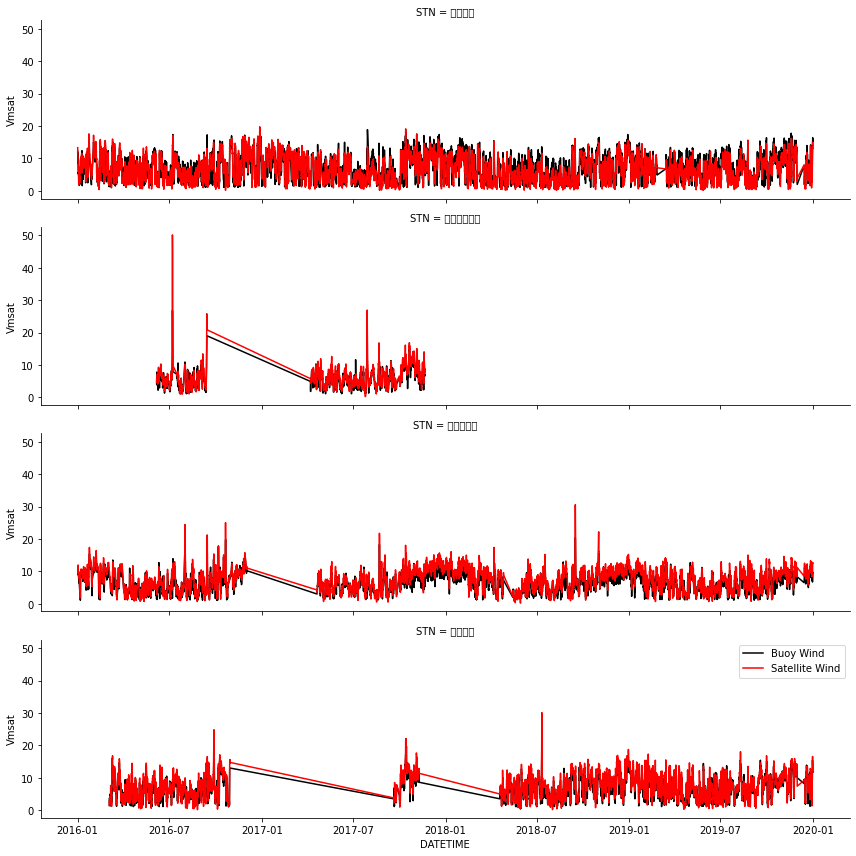

In [8]:
%matplotlib inline
plt.figure(figsize=(16,8),dpi=200)
g = sns.FacetGrid(dataset, col="STN", col_wrap=1, height=3, aspect=4)
g.map(sns.lineplot, 'DATETIME','Vm',color='k')
g.map(sns.lineplot, 'DATETIME','Vmsat',color='r')
plt.legend(labels=['Buoy Wind','Satellite Wind'])

### Remove Unnecessary Cloumn for ML

In [9]:
dataset.pop('DATETIME')
dataset.pop('ST')
dataset.pop('STN')

104311    新竹浮標
104317    新竹浮標
104323    新竹浮標
104329    新竹浮標
104335    新竹浮標
          ... 
877101    馬祖浮標
877107    馬祖浮標
877113    馬祖浮標
877119    馬祖浮標
877125    馬祖浮標
Name: STN, Length: 14206, dtype: object

In [10]:
dataset = dataset.dropna()
dataset.isna().sum()

H        0
Temp     0
P        0
Vm       0
Vmsat    0
dtype: int64

## SVM model

In [11]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

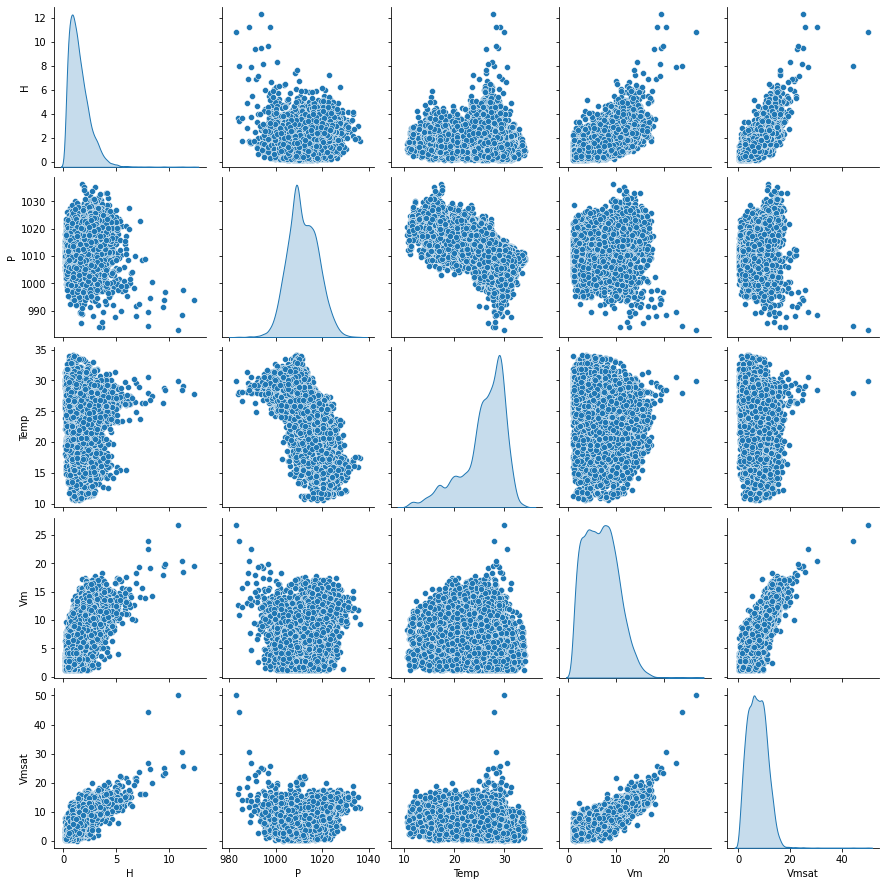

In [12]:
sns.pairplot(train_dataset[['H', 'P', 'Temp', 'Vm','Vmsat']], diag_kind='kde')

In [13]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Vm')
test_labels = test_features.pop('Vm')

### Build model

In [14]:
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1),
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})

In [15]:
history = svr.fit(np.array(train_features['Vmsat']).reshape(-1,1), train_labels)

### Test model 

In [16]:
x = np.linspace(0.0, 15, 251)[:,None]
y = svr.predict(x)

In [17]:
def plot_Vmsat(x, y):
  plt.scatter(train_features['Vmsat'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Vmsat')
  plt.ylabel('Vm')
  plt.legend()

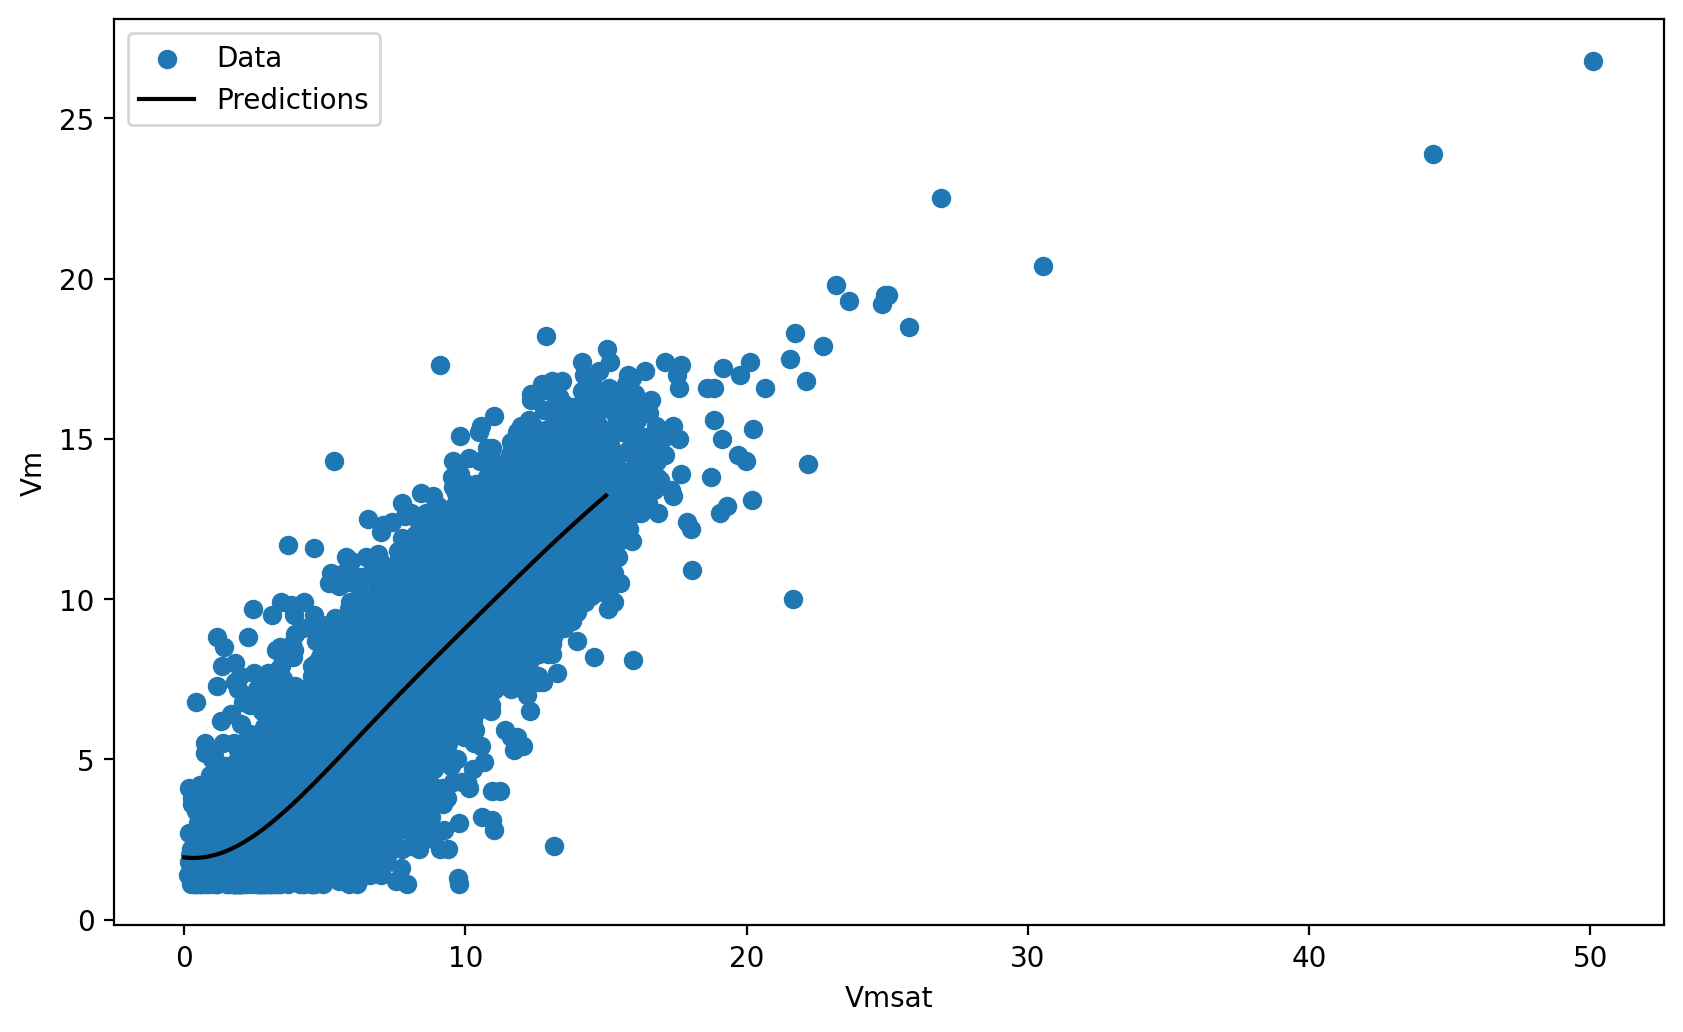

In [18]:
plt.figure(figsize=(10,6),dpi=200)
plot_Vmsat(x,y)

In [19]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 3])
  plt.xlabel('Epoch')
  plt.ylabel('Error [H]')
  plt.legend()
  plt.grid(True)

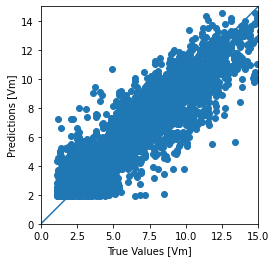

In [20]:
test_predictions = svr.predict(np.asarray(test_features['Vmsat'])[:,None]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Vm]')
plt.ylabel('Predictions [Vm]')
lims = [0, 15]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


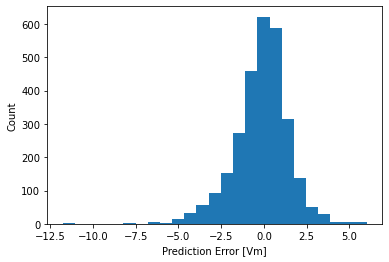

In [21]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Vm]')
_ = plt.ylabel('Count')